In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from skimage import io
from skimage.filters import gaussian

import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# Define CVAE and functions needed
class CVAE(nn.Module):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim, size):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.size = size
        reduced_size = size // 8
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * reduced_size * reduced_size, latent_dim * 2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, reduced_size * reduced_size * 32),
            nn.ReLU(),
            nn.Unflatten(1, (32, reduced_size, reduced_size)),
            nn.ConvTranspose2d(32, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1)
        )

    def encode(self, x):
        h = self.encoder(x)
        mean, logvar = torch.chunk(h, 2, dim=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = torch.sigmoid(logits)
            return probs
        return logits

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z)

def generate_images(model, epoch, test_sample):
    model.eval()
    with torch.no_grad():
        mean, logvar = model.encode(test_sample)
        z = model.reparameterize(mean, logvar)
        predictions = model.decode(z, apply_sigmoid=True)

    fig, axs = plt.subplots(4, 4, figsize=(4, 4))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(predictions[i, 0, :, :].cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(4, 4, figsize=(4, 4))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(test_sample[i, 0, :, :].cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = F.binary_cross_entropy_with_logits(x_logit, x, reduction='sum')
    logpx_z = -cross_ent
    logpz = log_normal_pdf(z, torch.zeros_like(z), torch.zeros_like(z))
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -torch.mean(logpx_z + logpz - logqz_x)

def log_normal_pdf(sample, mean, logvar):
    log2pi = torch.log(torch.tensor(2. * np.pi))
    return torch.sum(-0.5 * ((sample - mean) ** 2 * torch.exp(-logvar) + logvar + log2pi), dim=1)

def train_step(model, x, optimizer):
    model.train()
    optimizer.zero_grad()
    loss = compute_loss(model, x)
    loss.backward()
    optimizer.step()
    return loss.item()

def predict(model, inp_image, apply_sigmoid=True):
    model.eval()
    with torch.no_grad():
        mean, logvar = model.encode(inp_image)
        z = model.reparameterize(mean, logvar)
        predictions = model.decode(z, apply_sigmoid)
    return predictions[0, 0, :, :].cpu().numpy()

def get_testing_training_sets(image='20111206DF', size=64, n_images=10):
    training = []
    testing = []
    img = io.imread(image)
    width = len(img[0])
    height = len(img)
    try:
        img = img[:, :, 0]
    except:
        pass
    for i in range(n_images):
        shift_y = np.random.randint(height // 2, height - size)
        shift_x = np.random.randint(0, width - size)
        training.append(img[shift_y:shift_y + size, shift_x:shift_x + size])
        shift_y = np.random.randint(0, height // 2 - size)
        shift_x = np.random.randint(0, width - size)
        testing.append(img[shift_y:shift_y + size, shift_x:shift_x + size])
    return np.array(training), np.array(testing)

def gaussian_blur(img, sigma):
    return np.array(gaussian(img, (sigma, sigma)))

def gaussian_blur_arr(images, sigma):
    return np.array([gaussian_blur(img, sigma) for img in images])

def norm_max_pixel(images):
    return np.array([img / np.max(img) for img in images])

def preprocess_images(images, size, sigma):
    images = gaussian_blur_arr(images, sigma)
    images = norm_max_pixel(images)
    images = images.reshape((images.shape[0], 1, size, size))
    return images.astype('float32')

In [3]:
SIZE = 64 
SIGMA = 2
epochs = 200
latent_dim = 20
image_file = "20111206DF.jpg"
path = "data/"

# Load and preprocess data
training_set, testing_set = get_testing_training_sets(path + 'images_2D/' + image_file, SIZE, 1000)
mix_training_set = np.load(path + "raw_training_set_" + image_file.split('.')[0] + "_64.npy")
np.random.shuffle(mix_training_set)
testing_set = np.load(path + "raw_testing_set_" + image_file.split('.')[0] + "_64.npy")[:100]

train_images = preprocess_images(training_set, SIZE, SIGMA)
test_images = preprocess_images(testing_set, SIZE, SIGMA)

# Create data loaders
train_dataset = TensorDataset(torch.tensor(train_images))
test_dataset = TensorDataset(torch.tensor(test_images))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Instantiate model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CVAE(latent_dim, SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_examples_to_generate = 16
random_vector_for_generation = torch.randn(num_examples_to_generate, latent_dim).to(device)

# Save raw testing and training sets
np.save(path + "raw_training_set_" + image_file.split('.')[0] + "_64.npy", training_set)
np.save(path + "raw_testing_set_" + image_file.split('.')[0] + "_64.npy", testing_set)

# Pick a sample of the test set for generating output images
test_sample = next(iter(test_loader))[0][:num_examples_to_generate].to(device)

Epoch: 40, Test set ELBO: 2558.5342, time elapsed for current epoch: 0.54s


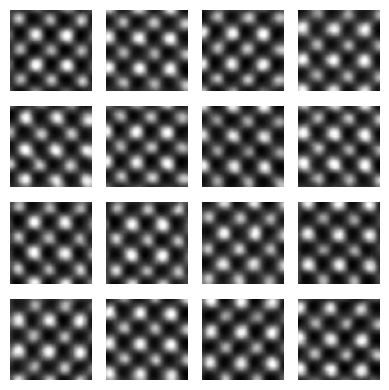

Training interrupted. Saving the model...


In [4]:
generate_images(model, 0, test_sample)
try: 
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        model.train()
        for batch in train_loader:
            train_x = batch[0].to(device)
            loss = compute_loss(model, train_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        end_time = time.time()

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                test_x = batch[0].to(device)
                test_loss += compute_loss(model, test_x).item()
        test_loss /= len(test_loader.dataset)
    
        display.clear_output(wait=False)
        print(f'Epoch: {epoch}, Test set ELBO: {test_loss:.4f}, time elapsed for current epoch: {end_time - start_time:.2f}s')
        generate_images(model, epoch, test_sample)
        
except KeyboardInterrupt:
    print("Training interrupted. Saving the model...")


In [ ]:
torch.save(model.state_dict(), image_file.strip(".jpg") + f'_Size{SIZE}_SIGMA{SIGMA}_epochs{epochs}_latentdim{latent_dim}.pth')